### Purpose: To generate final plots for Readability Study

### Dependancies:

In [1071]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import scipy.stats as st
import copy
from typing import Tuple, List, Dict, Optional
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)

### Functions:

In [1072]:
def rename_reorder(df):
    df = df.drop(columns={'text', 'link', 'pows', 'spac'}).copy(deep=True)
    #df = df.drop(columns={'hcs', 'aics'})

    rename_dict = {'smog': 'Smog Index', 'cole': 'Coleman-Liau Index', 'auto': 'Automated Readability Index', 'dale': 'Dale-Chall Index', 'forc': 'FORCAST Grade', 'gunn': 'Gunning-Fog Index', 'fleG2': 'Flesch-Kincaid Grade', 'fleS': 'Flesch Reading Ease Index'}
    df = df.rename(columns=rename_dict).copy(deep=True)

    new_order = ['rank', 'FORCAST Grade', 'Dale-Chall Index', 'Gunning-Fog Index', 'Flesch Reading Ease Index', 'Smog Index', 'Coleman-Liau Index', 'Flesch-Kincaid Grade', 'Automated Readability Index', 'word_count', 'aics', 'hcs']
    df = df.reindex(columns=new_order).copy(deep=True)
    
    return df   

In [1073]:
def bowleys_skew(series):
    q1, q3 = np.percentile(series, [25, 75])
    median = np.median(series)
    skew = (q3 - 2 * median + q1) / (q3 - q1)
    if not np.isnan(skew):
        return skew
    return -1

In [1074]:
def hist_subplot(df, col, sd=1, darkmode=False, ax=None):
    
    title_fontsize = 20
    label_fontsize = 16
    tick_fontsize = 16
    legend_fontsize = 12
    
    if darkmode:
        facecolor = '0.1'
        color1 = '#B3B3B3'
        color2 = 'green'
        color3 = 'red'
    else:
        facecolor = 'white'
        color1 = '#051D40'
        color2 = '#55aeff'
        color3 = '#FF5757'
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6), facecolor=facecolor)
    else:
        fig = ax.get_figure()
       
    mean_val = df[col].mean()
    sd_val = df[col].std() * sd
    bin_edges = np.arange(np.floor(df[col].min()) - 0.5, np.ceil(df[col].max()) + 1.5, 1)
    sns.histplot(data=df[col], kde=False, bins=bin_edges, color=color2, ax=ax, edgecolor=color1)
    ax.set_xlabel("", color=color1, fontsize=label_fontsize)
    ax.set_ylabel("", color=color1, fontsize=label_fontsize)
    ax.set_title(col, color=color1, fontsize=title_fontsize, fontweight='bold')
    skew = bowleys_skew(df[col])
    if not np.isnan(skew):
        ax.text(0.02, 0.95, f"Bowley Skewness: {skew:.4f}", fontsize=legend_fontsize, color=color1, transform=ax.transAxes)
        if abs(skew) > 0.5:
                ax.text(0.02, 0.92, 'Data is not normally distributed.', transform=ax.transAxes, fontsize=12, verticalalignment='top', color=color1)


    max_x = df[col].max()
    if max_x < 10.5:
        ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
        ax.set_xlim(-0.5, 10.5)
    #elif max_x < 14:
    #    ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
    #    ax.set_xlim(-0.5, 12.8)
    elif max_x < 21:
        ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20])
        ax.set_xlim(-0.5, 20.5)
    else:
        ax.set_xticks([0,10,20,30,40,50,60,70,80,90,100])
        ax.set_xlim(-0.5, 100.5)

    #ax.set_xlim(-0.5, max_x + 0.5)
    ax.set_ylim(0, None)
    #ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    if sd:
        ax.axvline(x=mean_val, color=color3)
        ax.axvline(x=mean_val + sd_val, color=color3, linestyle='--')
        ax.axvline(x=mean_val - sd_val, color=color3, linestyle='--')
        ax.legend([f"Mean {mean_val:.1f}", f"SD ±{sd_val:.1f}"], loc='upper right', facecolor=facecolor, edgecolor=color1, fontsize=legend_fontsize)

        for text in ax.legend_.get_texts():
            text.set_color(color1)
    
    ax.set_facecolor(facecolor)
    for spine in ax.spines.values():
        spine.set_edgecolor(color1)
        
    ax.tick_params(axis='x', colors=color1, labelsize=tick_fontsize)
    ax.tick_params(axis='y', colors=color1, labelsize=tick_fontsize)
    
    return fig, ax

In [1075]:
def plot_2x2_subplots(specs, title=None, darkmode=False):
    if len(specs) != 4:
        raise ValueError("The 'specs' list must contain exactly 4 tuples.")
    
    if darkmode:
        facecolor = '0.1'
        color1 = '#B3B3B3'

    else:
        facecolor = 'white'
        color1 = '#051D40'

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), facecolor=facecolor)
    for idx, ax in enumerate(axes.flatten()):
        #hist_subplot(*specs[idx], ax=ax)
        hist_subplot(*specs[idx][:3], darkmode=darkmode, ax=ax)
    
    if title is not None:
        fig.suptitle(f"{title}: Frequency vs. Score", fontsize=28, fontweight='bold', color=color1, y=0.99)
    
    fig.tight_layout()
    fig.savefig(f"figures/{title}.png")

    plt.show()

In [1076]:
def make_table(df, data):
    df_temp = df.copy(deep=True)
    
    title = 'Table 3: Correlation Summary'
    color1 = '#051D40'
    color2 = '#051D40'

    # Initialize an empty list to hold the summary tables
    tables = []

    # Loop through the tuples in data and calculate the summary statistics
    for df_temp, col in data:
        # Calculate the mean, standard deviation, median, mode and Bowley's skew
        col_mean = df_temp[col].mean()
        col_sd = df_temp[col].std()
        #col_median = np.median(df_temp[col])
        #col_mode = df_temp[col].mode().iloc[0]
        col_bowley = bowleys_skew(df_temp[col])

        # Calculate Spearman's correlation coefficient and p-value
        corr, pval = st.spearmanr(df_temp[col], df_temp['rank'])

        # Create a summary table for the column
        table = pd.DataFrame({
            #'Mean Grade': [f"{col_mean:.1f}" if not np.isnan(corr) else 'N/A'],
            #'SD': [f"{col_sd:.1f}" if not np.isnan(corr) else 'N/A'],
            #'Skew': [f"{col_bowley:.4f}" if not np.isnan(col_bowley) else 'N/A'],
            'Correlation Coeficient': [f"{corr:.4f}" if not np.isnan(corr) else 'N/A'],
            'P-Value': [f"{pval:.3e}" if not np.isnan(pval) else 'N/A']
        })
        table.index = [col]

        # Add the summary table to the list of tables
        tables.append(table)

    # Concatenate the summary tables into a single DataFrame
    summary_df = pd.concat(tables, axis=0)

    # Set up the table plot
    fig, ax = plt.subplots()
    ax.axis('off')
    #ax.axis('tight')

    # Create the table plot
    table = ax.table(cellText=summary_df.applymap(lambda x: f'{x:.4f}' if isinstance(x, float) else str(x)).values,
                     colLabels=summary_df.columns,
                     rowLabels=summary_df.index,
                     loc='center',
                     cellLoc='center')

    # row / col scales
    table.scale(1, 2)
    table.scale(1, 1)

    # Set the title of the table
    title_obj = ax.set_title(title, fontweight='bold', fontsize=16, color=color1)
    title_obj.set_position([.15, 0])

    # Format the cells of the table
    table.auto_set_font_size(False)
    table.set_fontsize(14)

    # Set the color of the cell text
    for cell in table.get_celld().values():
        cell.set_text_props(color=color1)

    # Set the color of the gridlines
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_linestyle('-')
            cell.set_edgecolor(color2)
        else:
            cell.set_linestyle('-')
            cell.set_edgecolor(color2)
    
    fig.savefig(f"figures/{'Table_3'}.png")
    # Show the plot
    plt.show()
    return tables

In [1088]:
def make_table2(df, column_names, figure_name):
    df_temp = df.copy(deep=True)
    
    title = f'{figure_name}'
    text_color = '#051D40'
    grid_color = '#051D40'

    # Select the specified columns from the DataFrame
    summary_df = df_temp[column_names]

    # Set up the table plot
    fig, ax = plt.subplots()
    ax.axis('off')

    # Create the table plot
    table = ax.table(cellText=summary_df.applymap(lambda x: f'{x:.4f}' if isinstance(x, float) else str(x)).values,
                     colLabels=summary_df.columns,
                     rowLabels=summary_df.index,
                     loc='center',
                     cellLoc='center')

    # row / col scales
    table.scale(1, 2)
    table.scale(1, 1)

    # Set the title of the table
    title_obj = ax.set_title(title, fontweight='bold', fontsize=16, color=text_color)
    title_obj.set_position([.15, 0])

    # Format the cells of the table
    table.auto_set_font_size(False)
    table.set_fontsize(14)

    # Set the color of the cell text
    for cell in table.get_celld().values():
        cell.set_text_props(color=text_color)

    # Set the color of the gridlines
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_linestyle('-')
            cell.set_edgecolor(grid_color)
        else:
            cell.set_linestyle('-')
            cell.set_edgecolor(grid_color)
    
    fig.savefig(f"figures/{figure_name}.png")
    # Show the plot
    plt.show()

In [1077]:
def plot_grades_old(data):
    # convert data to DataFrame
    df = pd.DataFrame(data, columns=['Readability System', 'Grade Mean', 'Grade Mode', 'SD'])

    # set index column to 'System'
    df.set_index('Readability System', inplace=True)

    # reverse the order of the rows
    df = df.iloc[::-1]

    # plot data
    ax = df.plot(kind='barh', figsize=(8, 6), grid=True)

    # move legend outside of graph area
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    # set axis labels and title
    ax.set_xlabel('Normalized Grade')
    ax.set_title('Normalized Grades vs. Readability System')

    # show plot
    plt.show()

In [1078]:
def plot_grades(data):
    # convert data to DataFrame
    df = pd.DataFrame(data, columns=['Readability System', 'Grade Mean', 'Grade Mode', 'SD'])

    # set index column to 'System'
    df.set_index('Readability System', inplace=True)

    # reverse the order of the rows
    df = df.iloc[::-1]

    # plot data
    ax = df.plot(kind='barh', figsize=(8, 6), grid=True)

    # set color scheme
    color1 = '#051D40'
    color2 = '#55aeff'
    color3 = '#FF5757'

    ax.set_title('Figure 3: Normalized Grade vs. Readability method', color=color1, fontsize=22)
    ax.tick_params(axis='x', colors=color1, labelsize=14)
    ax.set_xlim(0, 14)
    ax.tick_params(axis='y', colors=color1, labelsize=14)
    ax.set_xlabel('Normalized Grade', color=color1, fontsize=14)
    ax.set_ylabel('', color=color1, fontsize=14)
    ax.spines['bottom'].set_color(color1)
    ax.spines['left'].set_color(color1)

    ax.barh(df.index, df['Grade Mean'], color=color1, height=0.9)
    ax.barh(df.index, df['Grade Mode'], color=color2, height=0.5)
    ax.barh(df.index, df['SD'], color=color3, height=0.3)

    # create legend entries for each bar
    legend_elements = [Line2D([0], [0], color=color1, lw=9, label='Grade Mean'),
                       Line2D([0], [0], color=color2, lw=5, label='Grade Mode'),
                       Line2D([0], [0], color=color3, lw=3, label='Std. Dev.')]

    # add legend with custom entries
    legend = ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.0, 0.5), edgecolor=color1)
    for text in legend.get_texts():
        text.set_color(color1)


    ax.grid(color=color1)

    fig = ax.get_figure()
    fig.savefig(f"figures/{'Figure_3'}.png")

    # show plot
    plt.show()

### Code Execution:

In [1079]:
df = pd.read_csv('data/combined_final.csv')
df = rename_reorder(df)
df.tail(1)

,rank,FORCAST Grade,Dale-Chall Index,Gunning-Fog Index,Flesch Reading Ease Index,Smog Index,Coleman-Liau Index,Flesch-Kincaid Grade,Automated Readability Index,word_count,aics,hcs
13581,1,16.7,5.7,7.3,68.1,11.0,10.6,6.1,4.5,775.0,16.7,83.3


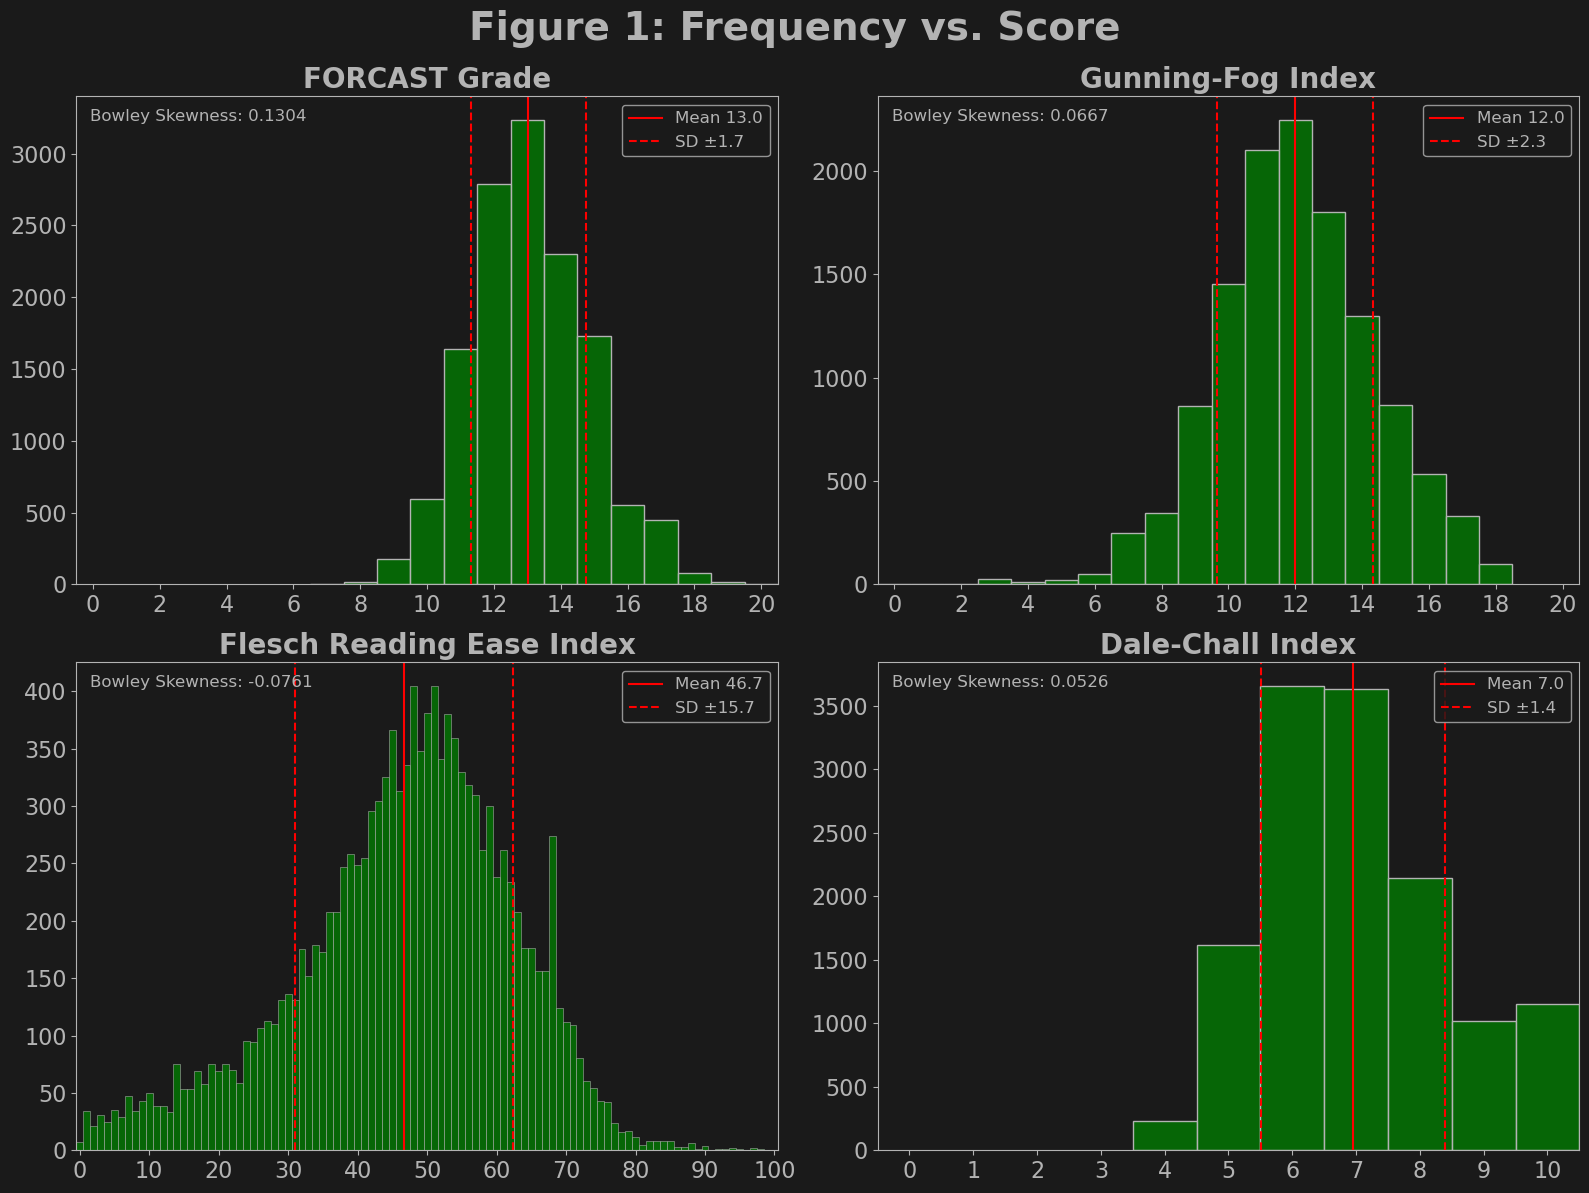

In [1087]:
col_1 = 'FORCAST Grade'
df_fg = df[(df[col_1] > 0) & (df[col_1] < 20)].copy(deep=True)
df_fg = df_fg[['rank', col_1, 'word_count', 'aics', 'hcs']]

col_2 = 'Gunning-Fog Index'
df_gfi = df[(df[col_2] > 0) & (df[col_2] < 17.9)].copy(deep=True)
df_gfi = df_gfi[['rank', col_2, 'word_count', 'aics', 'hcs']]

col_3 = 'Flesch Reading Ease Index'
df_fre = df[(df[col_3] > 0.1) & (df[col_3] < 99.9)].copy(deep=True)
df_fre = df_fre[['rank', col_3, 'word_count', 'aics', 'hcs']]

col_4 = 'Dale-Chall Index'
df_dci = df[(df[col_4] > 4) & (df[col_4] < 20)].copy(deep=True)
df_dci = df_dci[['rank', col_4, 'word_count', 'aics', 'hcs']]

specs = [(df_fg, col_1, 1), (df_gfi, col_2, 1), (df_fre, col_3, 1), (df_dci, col_4, 1)]

plot_2x2_subplots(specs, title='Figure 1', darkmode=True)

/tmp/ipykernel_2837/4026265569.py:4: RuntimeWarning: invalid value encountered in double_scalars
  skew = (q3 - 2 * median + q1) / (q3 - q1)


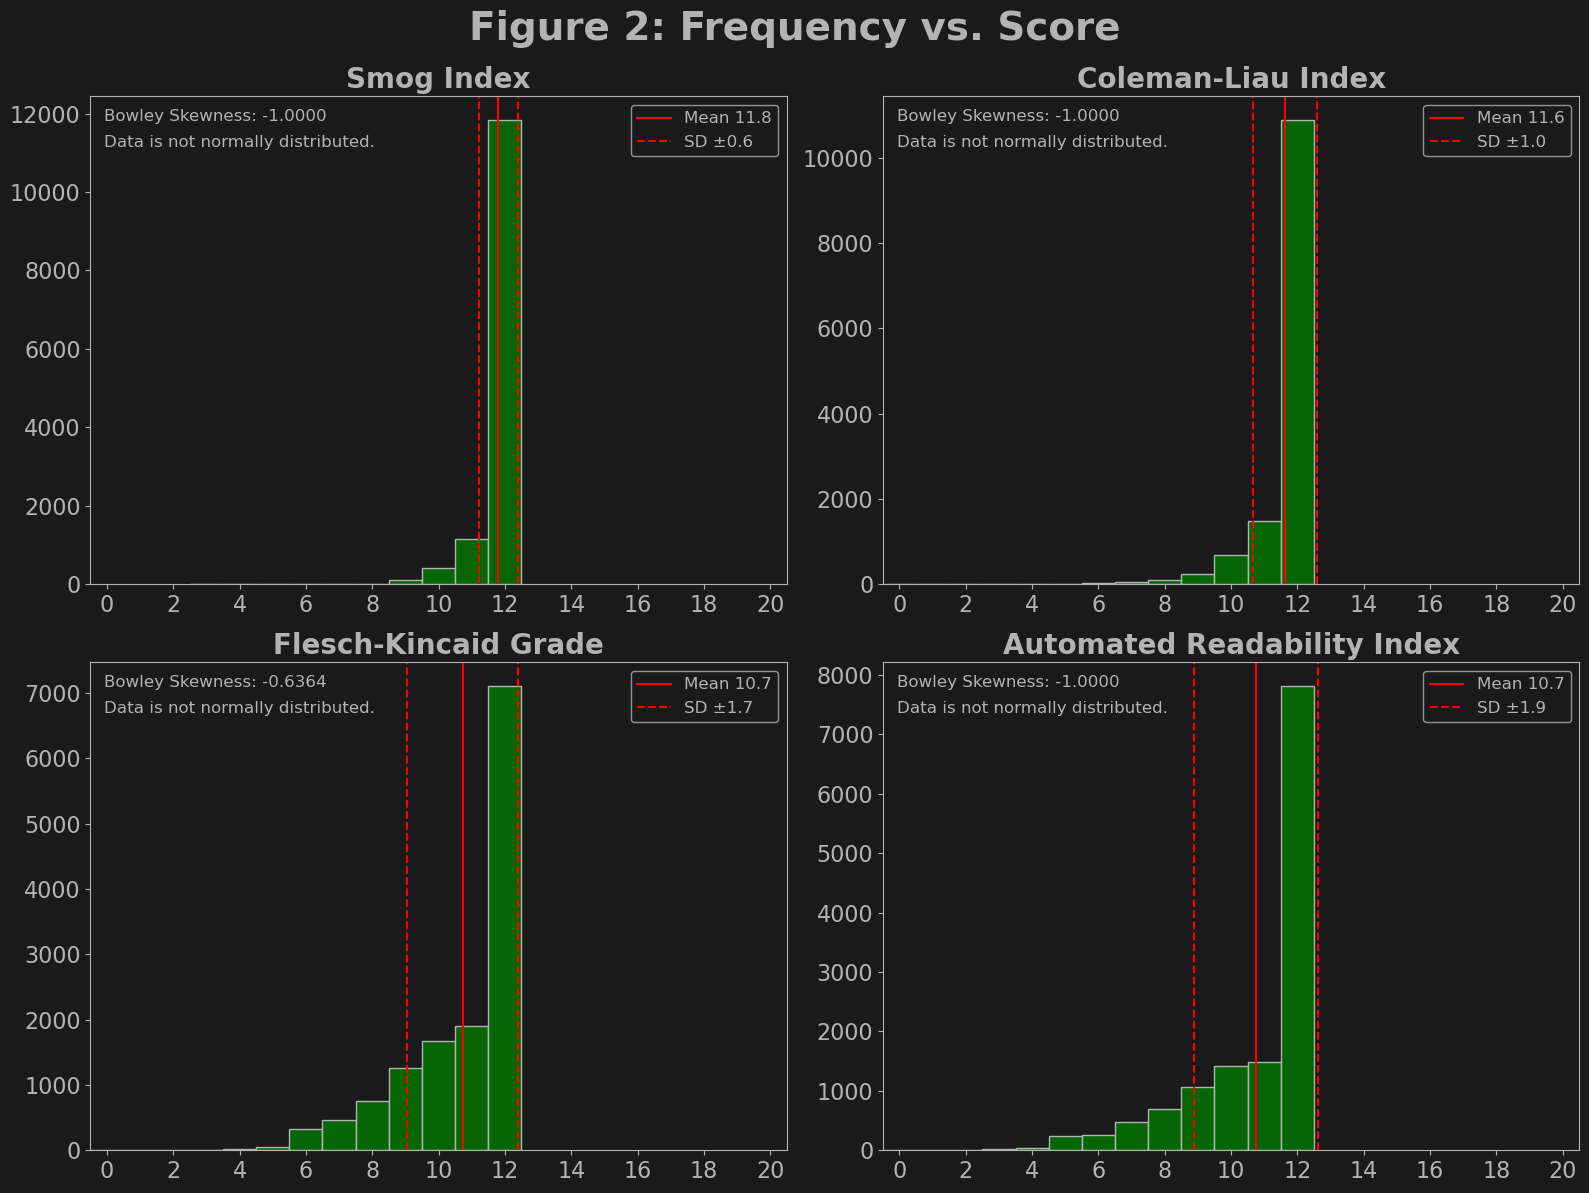

In [1081]:
col_1 =  'Smog Index'
df_si = df[(df[col_1] > 0) & (df[col_1] < 20)].copy(deep=True)
df_si = df_si[['rank', col_1, 'word_count', 'aics', 'hcs']]

col_2 = 'Coleman-Liau Index'
df_cli = df[(df[col_2] > 0) & (df[col_2] < 20)].copy(deep=True)
df_cli = df_cli[['rank', col_2, 'word_count', 'aics', 'hcs']]

col_3 = 'Flesch-Kincaid Grade'
df_fcg = df[(df[col_3] > 0) & (df[col_3] < 20)].copy(deep=True)
df_fcg = df_fcg[['rank', col_3, 'word_count', 'aics', 'hcs']]

col_4 = 'Automated Readability Index'
df_ari = df[(df[col_4] > 0) & (df[col_4] < 20)].copy(deep=True)
df_ari = df_ari[['rank', col_4, 'word_count', 'aics', 'hcs']]

specs = [(df_si, col_1, 1), (df_cli, col_2, 1), (df_fcg, col_3, 1), (df_ari, col_4, 1)]

plot_2x2_subplots(specs, title='Figure 2', darkmode=True)

/tmp/ipykernel_2837/4026265569.py:4: RuntimeWarning: invalid value encountered in double_scalars
  skew = (q3 - 2 * median + q1) / (q3 - q1)


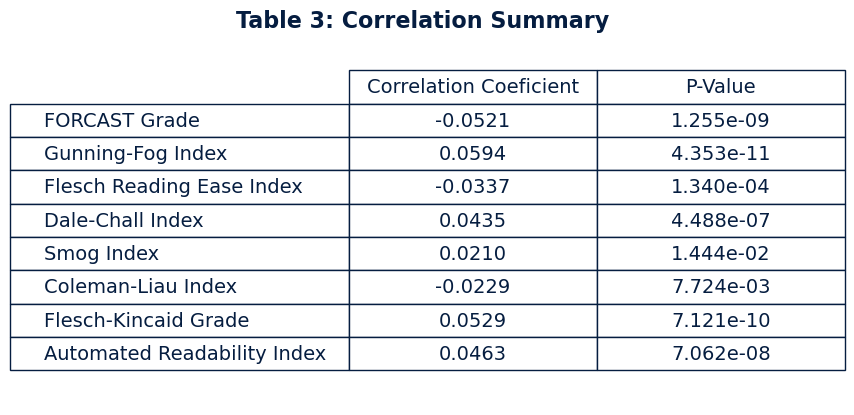

In [1082]:
data = [(df_fg, 'FORCAST Grade'), (df_gfi, 'Gunning-Fog Index'), (df_fre, 'Flesch Reading Ease Index'),
        (df_dci, 'Dale-Chall Index'), (df_si, 'Smog Index'), (df_cli, 'Coleman-Liau Index'),
        (df_fcg, 'Flesch-Kincaid Grade'), (df_ari,'Automated Readability Index' )]
out = make_table(df, data)

In [1083]:
type (out)

list

In [1084]:
x = [{'Readability System': 'FORCAST Grade',
  'Grade Mean': 13.0,
  'Grade Mode': 13.0,
  'SD': 1.7,
  'Skew': 0.1304,
  'Corr. Coef.': -0.0521,
  'P-Value': 1.255e-09},
 {'Readability System': 'Gunning-Fog',
  'Grade Mean': 12.0,
  'Grade Mode': 12.0,
  'SD': 2.3,
  'Skew': 0.0667,
  'Corr. Coef.': 0.0594,
  'P-Value': 4.353e-11},
 {'Readability System': 'Flesch Reading Ease',
  'Grade Mean': 13.5,
  'Grade Mode': 13.0,
  'SD': 3.1,
  'Skew': -0.0761,
  'Corr. Coef.': -0.0337,
  'P-Value': 0.000134},
  {'Readability System': 'Dale-Chall',
  'Grade Mean': 9.0,
  'Grade Mode': 9.0,
  'SD': 2.8,
  'Skew': 0.125,
  'Corr. Coef.': 0.0034,
  'P-Value': 0.7078},
 {'Readability System': 'Smog',
  'Grade Mean': 11.8,
  'Grade Mode': 12.0,
  'SD': 0.6,
  'Skew': -1.0,
  'Corr. Coef.': 0.021,
  'P-Value': 0.01444},
 {'Readability System': 'Coleman-Liau',
  'Grade Mean': 11.6,
  'Grade Mode': 12.0,
  'SD': 1.0,
  'Skew': -1.0,
  'Corr. Coef.': -0.0229,
  'P-Value': 0.007724},
 {'Readability System': 'Flesch-Kincaid Grade',
  'Grade Mean': 10.7,
  'Grade Mode': 12.0,
  'SD': 1.7,
  'Skew': -0.6364,
  'Corr. Coef.': 0.0529,
  'P-Value': 7.121e-10},
 {'Readability System': 'Automated Readability',
  'Grade Mean': 10.7,
  'Grade Mode': 12.0,
  'SD': 1.9,
  'Skew': -1.0,
  'Corr. Coef.': 0.0463,
  'P-Value': 7.062e-08}]

In [1085]:
df_table = pd.DataFrame.from_dict(x) 
df_table['SD'] = df_table['SD'].astype(float)
df_table['Grade Mean'] = df_table['Grade Mean'].astype(float)
df_table['Grade Mode'] = df_table['Grade Mode'].astype(float)
df_table

,Readability System,Grade Mean,Grade Mode,SD,Skew,Corr. Coef.,P-Value
0,FORCAST Grade,13.0,13.0,1.7,0.1304,-0.0521,1.255000e-09
1,Gunning-Fog,12.0,12.0,2.3,0.0667,0.0594,4.353000e-11
2,Flesch Reading Ease,13.5,13.0,3.1,-0.0761,-0.0337,1.340000e-04
3,Dale-Chall,9.0,9.0,2.8,0.1250,0.0034,7.078000e-01
4,Smog,11.8,12.0,0.6,-1.0000,0.0210,1.444000e-02
5,Coleman-Liau,11.6,12.0,1.0,-1.0000,-0.0229,7.724000e-03
6,Flesch-Kincaid Grade,10.7,12.0,1.7,-0.6364,0.0529,7.121000e-10
7,Automated Readability,10.7,12.0,1.9,-1.0000,0.0463,7.062000e-08


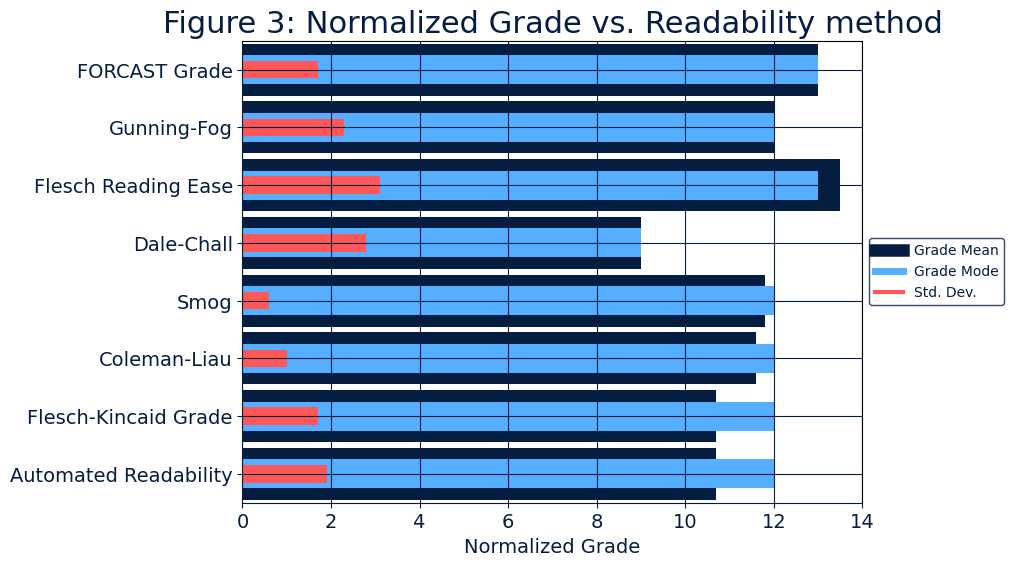

In [1086]:
plot_grades(df_table)

In [1093]:
table_1 = [
    {'Score': '4.9 or lower', 'Notes': 'Easily understood by an average 4th-grade student or lower'},
    {'Score': '5.0 – 5.9', 'Notes': 'Easily understood by an average 5th- or 6th-grade student'},
    {'Score': '6.0 – 6.9', 'Notes': 'Easily understood by an average 7th- or 8th-grade student'},
    {'Score': '7.0 – 7.9', 'Notes': 'Easily understood by an average 9th- or 10th-grade student'},
    {'Score': '8.0 – 8.9', 'Notes': 'Easily understood by an average 11th- or 12th-grade student'},
    {'Score': '9.0 – 9.9', 'Notes': 'Easily understood by an average college student'}
    ]
df_table_1 = pd.DataFrame.from_dict(table_1)
df_table_1

,Score,Notes
0,4.9 or lower,Easily understood by an average 4th-grade stud...
1,5.0 – 5.9,Easily understood by an average 5th- or 6th-gr...
2,6.0 – 6.9,Easily understood by an average 7th- or 8th-gr...
3,7.0 – 7.9,Easily understood by an average 9th- or 10th-g...
4,8.0 – 8.9,Easily understood by an average 11th- or 12th-...
5,9.0 – 9.9,Easily understood by an average college student


In [1124]:
def make_table2(df, column_names, figure_name, figure_desc=''):
    df_temp = df.copy(deep=True)
    
    title = f'{figure_name}: ' + figure_desc
    text_color = '#051D40'
    grid_color = '#051D40'

    # Select the specified columns from the DataFrame
    summary_df = df_temp[column_names]

    # Set up the table plot
    fig, ax = plt.subplots()
    ax.axis('off')

    # Create the table plot
    table = ax.table(cellText=summary_df.applymap(lambda x: f'{x:.4f}' if isinstance(x, float) else str(x)).values,
                     colLabels=summary_df.columns,
                     loc='center',
                     cellLoc='center')

    # Set the title of the table
    title_obj = ax.set_title(title, fontweight='bold', fontsize=16, color=text_color)
    title_obj.set_position([.5, 1.05])

    # Format the cells of the table
    table.auto_set_font_size(False)
    table.set_fontsize(14)

    # Set the color of the cell text
    for cell in table.get_celld().values():
        cell.set_text_props(color=text_color)

    # Set the color of the gridlines
    for key, cell in table.get_celld().items():
        cell.set_linestyle('-')
        cell.set_edgecolor(grid_color)
    
    # Adjust the size of the columns to fit the length of the content in each column
    table.auto_set_column_width(col=list(range(len(column_names))))

    # Increase the height of each row by 100%
    table.scale(1, 2.5)

    fig.savefig(f"figures/{figure_name}.png")
    # Show the plot
    plt.show()

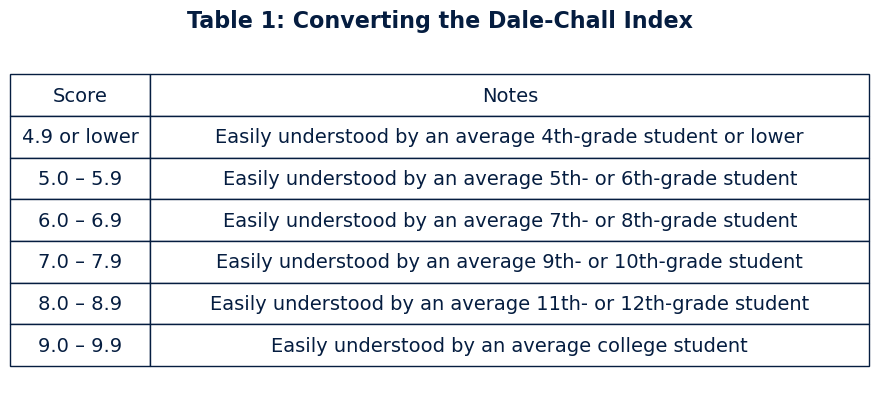

In [1125]:
make_table2(df=df_table_1, column_names=['Score', 'Notes'], figure_name='Table 1', figure_desc='Converting the Dale-Chall Index')

In [1091]:
table_2 = [
    {'Score': '100 – 90', 'School Level(US)': '5th grade', 'Notes': 'Very easy to read. Easily understood by an average 11-year-old student.'},
    {'Score': '90 – 80', 'School Level(US)': '6th grade', 'Notes': 'Easy to read. Conversational English for consumers.'},
    {'Score': '80 – 70', 'School Level(US)': '7th grade', 'Notes': 'Fairly easy to read.'},
    {'Score': '70 – 60', 'School Level(US)': '8th & 9th grade', 'Notes': 'Plain English. Easily understood by 13- to 15-year-old students.'},
    {'Score': '60 – 50', 'School Level(US)': '10th to 12th grade', 'Notes': 'Fairly difficult to read.'},
    {'Score': '50 – 30', 'School Level(US)': 'College', 'Notes': 'Difficult to read.'},
    {'Score': '30 – 10', 'School Level(US)': 'College graduate', 'Notes': 'Very difficult to read. Best understood by university graduates.'},
    {'Score': '10 – 0', 'School Level(US)': 'Professional', 'Notes': 'Extremely difficult to read. Best understood by university graduates.'}
    ]